# Early stages instruments dataset - Data exploration

This notebook starts from the files generated at step 02 ('02_buyers_sellers_df.ipynb' notebook) and performs a general analysis/visualization on the buyers/sellers related data.

## Data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sys

from bokeh.io import show, output_notebook

import scripts_viz.visualization_utils as viz

sns.set()
output_notebook()

Loading BokehJS ...

In [2]:
#instruments - buyers - sellers dataset
#import data
datafolder = "../data/"

prefix = "inst_"
inst = pd.read_pickle(datafolder + "02_instrumentsdf_2.pkl")
buyer = pd.read_pickle(datafolder + prefix+ "buyer.pkl")
seller = pd.read_pickle(datafolder + prefix+ "seller.pkl")

ReportDate = pd.to_datetime('2018-09-28', yearfirst=True) #date we received the data

#%matplotlib notebook

In [3]:
inst.columns

Index(['customer_id', 'customer_name_1', 'debtor_id', 'debtor_name_1',
       'invoice_number', 'invoice_date', 'due_date', 'invoice_amount',
       'purchase_amount', 'purchase_amount_open', 'discharge_type',
       'discharge_amount', 'discharge_date', 'posting_date',
       'transaction_type', 'document_stack_id', 'booking_text', 'input_date',
       'creation_date', 'factoring_type', 'debt_collection_date',
       'last_payment_date', 'reminder_date', 'test_feature_tested',
       'test_characteristic_id', 'bill_id', 'cancellation_date', 'value_date',
       'currency', 'purchase_examination', 'prosecution', 'deduction_amount',
       'payment_amount', 'payment_date', 'document_status', 'uid', 'ttype',
       'nrecords', 'ttypeset', 'discharge_loss', 'has_impairment1',
       'has_prosecution', 'is_pastdue', 'is_pastdue30', 'is_pastdue90',
       'is_pastdue180', 'last_payment_amount', 'total_repayment',
       'total_impairment', 'is_open', 'we_payment_share', 'has_purchase',
    

### Visualizing features

C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\DavideMariani\Anaconda3\envs\mlflow\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


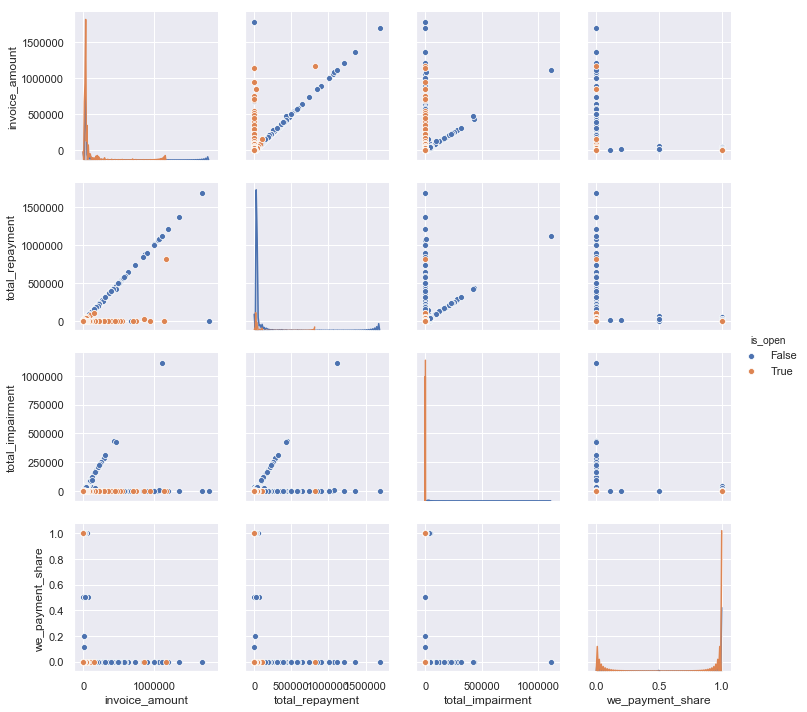

In [4]:
sns.pairplot(data=inst, vars=['invoice_amount', 'total_repayment', 'total_impairment', 'we_payment_share'], hue='is_open')

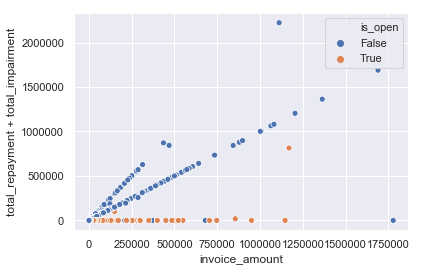

In [5]:
inst['total_repayment + total_impairment'] = inst.total_repayment + inst.total_impairment
sns.scatterplot(x=inst.invoice_amount, y=inst['total_repayment + total_impairment'], hue='is_open', data=inst)

In [6]:
ct = pd.crosstab(inst.has_purchase, inst["has_impairment1"], margins=True)
ct

has_impairment1,False,True,All
has_purchase,,,
False,11131,332,11463
True,47457,900,48357
All,58588,1232,59820


In [7]:
ct = pd.crosstab(inst.has_purchase, inst["is_pastdue90"], margins=True)
ct

is_pastdue90,False,True,All
has_purchase,,,
False,10324,1139,11463
True,45301,3056,48357
All,55625,4195,59820


In [8]:
ct = pd.crosstab(inst.has_purchase, inst["is_pastdue180"], margins=True)
ct

is_pastdue180,False,True,All
has_purchase,,,
False,10545,918,11463
True,45674,2683,48357
All,56219,3601,59820


[(0, 60000)]

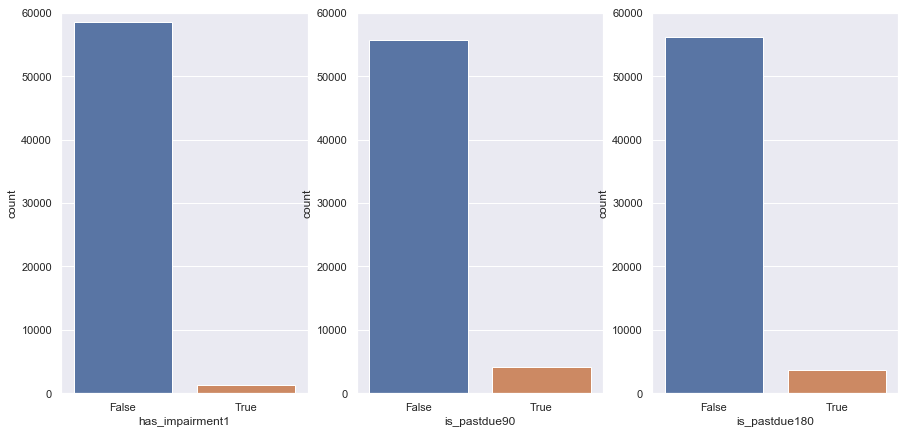

In [9]:
fig, ax =plt.subplots(1,3, figsize=(15,7))
a = sns.countplot(inst['has_impairment1'], ax=ax[0])
a.set(ylim=(0,60000))
b=sns.countplot(inst['is_pastdue90'], ax=ax[1])
b.set(ylim=(0,60000))
c=sns.countplot(inst['is_pastdue180'], ax=ax[2])
c.set(ylim=(0,60000))
#sns.countplot(inst.has_impairment1)

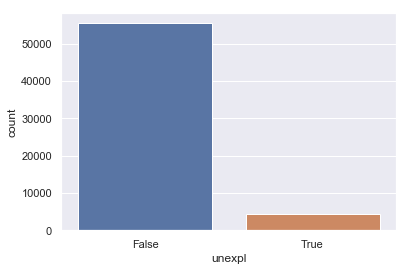

In [10]:
sns.countplot(inst.unexpl)

In [11]:
sum(inst.unexpl) #number of instruments with unexplained cashflows

4319

In [12]:
def _xor0(x):
    return 0. if np.isnan(x) else x
xor0 = np.vectorize(_xor0)

In [13]:
dp = viz.distplot(xor0(inst.total_impairment[inst.has_impairment1]/inst.invoice_amount[inst.has_impairment1]), bins=150,
                 xaxisname = "ratio: total impariment / invoice amount  for instruments having impairment_1")
show(dp)

In [14]:
#count and intersection of two boolean features
def intersect_feat(df, feat):
    for f in feat:
        print("{:}: {:} ({:.2f}%)".format(f, sum(df[f]), 100*sum(df[f])/df.shape[0])) 
    
    bothc = np.dot(*(df[feat[0]].astype(float), df[feat[1]].astype(float))) 
    print("&: {:.0f} ({:.2f}%/{:.2f}%)".format(bothc, 100*bothc/sum(df[feat[1]]), 100*bothc/sum(df[feat[0]]))) 
              
intersect_feat(inst, ["has_deduction", "has_discharge"])

has_deduction: 1232 (2.06%)
has_discharge: 2696 (4.51%)
&: 12 (0.45%/0.97%)


In [15]:
def signlog(X):
        X1=np.float32(X.copy())
        nanidx = np.isnan(X1)
        X1[~nanidx] = np.sign(X1[~nanidx]) * np.log(np.abs(X1[~nanidx])+1.)
        return X1

In [16]:
dp2 = viz.stacked_distplot(signlog(inst.invoice_amount), signlog(inst.total_repayment + inst.total_impairment), bins=150, density=False,
                          legendnames=['invoice_amount', 'total_repayment + total_impairment'], 
                           title='Stacked distribution plot of invoice_amount and the sum of total_repayment and total_impairment',
                          xaxisname='log distribution', yaxisname = 'amount')
show(dp2)

In [26]:
nrp = ((inst.unexpl > 0.01)&(~inst.is_open))
dp3 = viz.stacked_distplot(inst.invoice_date.apply(lambda x: x.toordinal()), inst.invoice_date[nrp].apply(lambda x: x.toordinal()), bins=150, density=False,
                          legendnames=['total instruments', 'instruments with unexplained cash flows'], xaxisname = 'date as ordinal', yaxisname='number of instruments')
show(dp3)

In [55]:
dp4 = viz.distplot(signlog(inst.total_impairment[inst.has_impairment1]/inst.invoice_amount[inst.has_impairment1]), bins=50)
show(dp4)

In [56]:
intersect_feat(inst, ["is_pastdue180", "has_prosecution"])

is_pastdue180: 3601 (6.02%)
has_prosecution: 1026 (1.72%)
&: 834 (81.29%/23.16%)


In [57]:
pd.crosstab(inst["is_pastdue180"], inst["has_prosecution"], margins=True, normalize=True)

has_prosecution,False,True,All
is_pastdue180,,,
False,0.936593,0.003210,0.939803
True,0.046255,0.013942,0.060197
All,0.982849,0.017151,1.000000


# Past due receivable class definitions

In [58]:
#defintion 1

ND=90
pd1 = inst.due_date.apply(lambda x: (ReportDate - x).days > ND) & inst.ttypeset.apply(lambda x: set(x).isdisjoint({1,5,6,7,9}))
print("Defintion 1: {:}/{:} past due by {:} days".format(sum(pd1), inst.shape[0], ND)) 

pd2 = inst.due_date.apply(lambda x: (ReportDate - x).days > ND) & (inst.document_status=="offen")
print("Defintion 2: {:}/{:} past due by {:} days; 1&2:{:}".format(sum(pd2), inst.shape[0], ND, sum(pd1&pd2))) 

Defintion 1: 3977/59820 past due by 90 days
Defintion 2: 3994/59820 past due by 90 days; 1&2:3902


In [59]:
#studying the difference
pd1_2 = pd1&~pd2 #additional payment event transaction types
pd2_1 = pd2&~pd1 #partial repayments
inst[pd2_1].head().transpose()

uid,1063:INTER715/11390,4195:588/1368,2016-1391:73/6605,2016-2352:1273/8680,293:26/10124
customer_id,2004019,2004019,2004024,2004019,2004020
customer_name_1,Beverly S.p.a.,Beverly S.p.a.,Teresa Protrudes and Culpas Limited,Beverly S.p.a.,McKesson Gumptia Inc.
debtor_id,INTER715,588,73,1273,26
debtor_name_1,Aberdeen Retards and Phalaropes S.p.a.,Ivanhoe Biles SA,Holst Inc.,Greenberg Limited,Astarte Cadaverouses Inc.
invoice_number,1063,4195,2016-1391,2016-2352,293
invoice_date,2014-04-16 00:00:00,2015-12-01 00:00:00,2016-08-02 00:00:00,2016-09-27 00:00:00,2016-11-08 00:00:00
due_date,2014-04-26 00:00:00,2015-12-11 00:00:00,2016-09-01 00:00:00,2016-10-07 00:00:00,2016-12-08 00:00:00
invoice_amount,2257.2,3199.5,8420.8,2845.25,855291
purchase_amount,0,3199.5,0,0,373373
purchase_amount_open,0,1328,0,0,354658


In [60]:
inst[pd1_2].head().transpose()

uid,4325GU:244/227,4325GU:244/228,14-103:1070012/101,1128:62230/1579,2015-710:37/51421
customer_id,2004008,2004008,che2004011,2004022,2004024
customer_name_1,Castillo GmbH,Castillo GmbH,Fredrickson GmbH,Cooperative Inventors Corporation,Teresa Protrudes and Culpas Limited
debtor_id,244,244,1070012,62230,37
debtor_name_1,Boltzmann Co.,Boltzmann Co.,Lathrop Robots Corporation,McKesson Gumptia Inc.,United Multinomials Co.
invoice_number,4325GU,4325GU,14-103,1128,2015-710
invoice_date,2014-07-31 00:00:00,2014-07-31 00:00:00,2014-11-14 00:00:00,2015-07-09 00:00:00,2016-01-12 00:00:00
due_date,2014-07-31 00:00:00,2014-07-31 00:00:00,2015-05-14 00:00:00,2015-08-08 00:00:00,2016-02-11 00:00:00
invoice_amount,140.95,177.2,8010.2,11422.1,2282.8
purchase_amount,140.95,177.2,8010.2,11422.1,0
purchase_amount_open,0,0,0,0,0


In [61]:
#transaction type signatures for non-open instruments without repayment events
inst.ttypeset[pd1_2].value_counts()

(0, 11)          22
(0, 15)          18
(0, 2, 11)       18
(0, 11, 3)       12
(0, 11, 2, 3)     3
(0, 14)           1
(0, 2, 14)        1
Name: ttypeset, dtype: int64

In [62]:
inst[pd1_2 & (inst.ttypeset==(0,14))].transpose()

uid,14-103:1070012/101
customer_id,che2004011
customer_name_1,Fredrickson GmbH
debtor_id,1070012
debtor_name_1,Lathrop Robots Corporation
invoice_number,14-103
invoice_date,2014-11-14 00:00:00
due_date,2015-05-14 00:00:00
invoice_amount,8010.2
purchase_amount,8010.2
purchase_amount_open,0


 ## Basic statistics

In [63]:
viz.show_stats(inst, buyer, seller)

59820 instruments,
  has_purchase: 48357 (80.8%)
  is_open: 8213 (13.7%)
  has_impairment1: 1232 (2.1%)
  is_due: 57619 (96.3%)
  is_pastdue90: 4195 (7.0%)
  is_pastdue180: 3601 (6.0%)
  has_prosecution: 1026 (1.7%)
  has_deduction: 1232 (2.1%)
3234 buyers,
  1.17 sellers per buyer
  18.50 instruments per buyer
    has_impairment1: 0.4 average instruments, 412(12.7%) with some
    is_pastdue90: 1.3 average instruments, 555(17.2%) with some
    is_pastdue180: 1.1 average instruments, 469(14.5%) with some
    has_prosecution: 0.3 average instruments, 67(2.1%) with some
    is_open: 2.5 average instruments, 1213(37.5%) with some
130 sellers,
  29.14 buyers per seller
  460.15 instruments per seller
    has_impairment1: 9.5 average instruments, 68(52.3%) with some
    is_pastdue90: 32.3 average instruments, 86(66.2%) with some
    is_pastdue180: 27.7 average instruments, 70(53.8%) with some
    has_prosecution: 7.9 average instruments, 26(20.0%) with some
    is_open: 63.2 average instrume

In [64]:
report = viz.save_stats("Full dataset", inst, buyer, seller)
report

,Full dataset
label,
no of instruments,59820
has_purchase,48357 (80.8%)
is_open,8213 (13.7%)
has_impairment1,1232 (2.1%)
is_due,57619 (96.3%)
is_pastdue90,4195 (7.0%)
is_pastdue180,3601 (6.0%)
has_prosecution,1026 (1.7%)
has_deduction,1232 (2.1%)


## Date sequence for a given instrument

In [65]:
#which date fields to use for ranking?
inst["first_posting_date"] = inst.posting_date.apply(lambda x: min(x))
inst["last_posting_date"] = inst.posting_date.apply(lambda x: max(x))
datecol = [  'due_date', 
           #"invoice_date", #almost always the earliest
       'discharge_date',  'input_date', 'creation_date', 
       'debt_collection_date', 'last_payment_date', 'reminder_date',
       'cancellation_date', 'value_date',
       'first_posting_date', 'last_posting_date']

inst["min_date"] = inst[datecol].min(axis=1)
inst["min_date_col"] = inst[datecol].idxmin(axis=1)
inst.min_date_col.value_counts()
#invoice_date is usually the earliest
#inst is already sorted by invoice_date

input_date            38546
value_date            18829
due_date               1334
reminder_date           923
last_payment_date       132
creation_date            46
first_posting_date       10
Name: min_date_col, dtype: int64

In [66]:
#days past invoice date
for c in datecol:
    inst["dd_"+c] = (inst[c] - inst.invoice_date).apply(lambda x: x.days)

In [67]:
inst[["dd_"+c for c in datecol]].describe()

,dd_due_date,dd_discharge_date,dd_input_date,dd_creation_date,dd_debt_collection_date,dd_last_payment_date,dd_reminder_date,dd_cancellation_date,dd_value_date,dd_first_posting_date,dd_last_posting_date
count,59820.000000,2696.000000,59820.000000,59820.000000,1390.000000,47639.000000,14820.000000,1511.000000,59820.000000,59820.000000,59820.000000
mean,31.677165,281.556751,12.014243,12.310481,208.034532,51.011881,110.464845,36.984116,3.342210,11.890689,62.079321
std,25.534198,248.543794,69.247315,69.268874,124.380181,61.300571,118.352168,83.650565,232.939328,69.063764,97.185396
min,0.000000,0.000000,-365.000000,-365.000000,59.000000,-559.000000,-280.000000,-365.000000,0.000000,-365.000000,-365.000000
25%,10.000000,81.000000,0.000000,0.000000,140.000000,16.000000,43.000000,1.000000,0.000000,0.000000,14.000000
50%,30.000000,175.500000,0.000000,0.000000,181.000000,32.000000,86.000000,13.000000,0.000000,0.000000,32.000000
75%,30.000000,483.250000,1.000000,2.000000,224.000000,63.000000,145.000000,70.000000,0.000000,1.000000,70.000000
max,395.000000,1326.000000,974.000000,974.000000,1036.000000,1315.000000,1204.000000,419.000000,32871.000000,974.000000,1326.000000


In [68]:
inst2=inst.copy().dropna(subset=['dd_discharge_date', 'dd_last_payment_date'])

dp4 = viz.distplot(inst2.dd_discharge_date-inst2.dd_last_payment_date, bins=100)
show(dp4)

In [69]:
#template for dependency study
#target feature
alltargetf = ["has_impairment1","has_impairment2","is_pastdue90","is_pastdue180",
              "has_prosecution", "has_deduction"]
#instrument level - two binary features
targetf = "has_deduction"
obsf = "has_purchase"
pd.crosstab(inst[obsf], inst[targetf], margins=True, normalize="index")

has_deduction,False,True
has_purchase,,
False,0.971037,0.028963
True,0.981388,0.018612
All,0.979405,0.020595
